In [28]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pymongo
import numpy as np
from slugify import slugify
import datetime

import glob

In [3]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["covid19"]
tblPacientes = mydb["pacientes"]
tblExames = mydb["pacientes_desfechos_exames"]
tblPD = mydb["pacientes_desfechos"]



In [4]:
def updateAllPaciente(tbl):
    tbl.update_many({}, {"$set": {"DESNUTRICAO": False, "ACIDOSE":  False,
                                    "ACIDOSE_METABOLICA": False, "ACIDOSE_RESPIRATORIA": False,
                                    "ALCALOSE_METABOLICA": False, "ALCALOSE_RESPIRATORIA": False
                                   }})

In [5]:
def updatePaciente(mycol, ID, values):
    myquery = { "ID_PACIENTE": ID }
    newvalues = { "$set": values }
    mycol.update_one(myquery, newvalues)
    
#updatePaciente(tblPacientes, "EC16E23E0501C13ECA19B9C3BE79B375", { "DESNUTRICAO": 0, "OXIGENIO": 0})


In [245]:
updateAllPaciente(tblPacientes)

In [246]:
def updateDesnutricao(tblPacientes, tblExames):
    myquery = {"DE_EXAME": "Albumina",
        "$expr": { "$not": {"$and": [
            {"$gte": [{"$convert": {"input": "$DE_RESULTADO", "to": "double", "onError": "$DE_RESULTADO" }}, 3.5]} ,
            {"$lte": [{"$convert": {"input": "$DE_RESULTADO", "to": "double", "onError": "$DE_RESULTADO" }}, 5.2]} ,
            ]}{ "DESNUTRICAO": True}
        }}

    mydoc = tblExames.find(myquery)

    for d in mydoc:
        updatePaciente(tblPacientes, d['ID_PACIENTE'], 
                       "DESNUTRICAO": True})


In [247]:
updateDesnutricao(tblPacientes, tblExames)

In [248]:
def updateAcidose(tblPacientes, tblExames):
    myquery = {
        "DE_EXAME": "Gasometria Arterial",
        "DE_ANALITO": "pO2 arterial",
        "$expr": { "$not": {"$and": [
            {"$gte": [{"$convert": {"input": "$DE_RESULTADO", "to": "double", "onError": "$DE_RESULTADO" }}, 80]} ,
            {"$lte": [{"$convert": {"input": "$DE_RESULTADO", "to": "double", "onError": "$DE_RESULTADO" }}, 100]} ,
            ]}
        }}

    mydoc = tblExames.find(myquery)

    for d in mydoc:
        updatePaciente(tblPacientes, d['ID_PACIENTE'], { "ACIDOSE": True})

def updateAcidoseFromVenoso(tblPacientes, tblExames):
    myquery = {
        "DE_EXAME": "Gasometria Venosa",
        "DE_ANALITO": "pO2 venoso",
        "$expr": { "$not": {"$and": [
            {"$gte": [{"$convert": {"input": "$DE_RESULTADO", "to": "double", "onError": "$DE_RESULTADO" }}, 30]} ,
            {"$lte": [{"$convert": {"input": "$DE_RESULTADO", "to": "double", "onError": "$DE_RESULTADO" }}, 50]} ,
            ]}
        }}

    mydoc = tblExames.find(myquery)

    for d in mydoc:
        updatePaciente(tblPacientes, d['ID_PACIENTE'], { "ACIDOSE": True})
    

In [249]:
updateAcidose(tblPacientes, tblExames)
updateAcidoseFromVenoso(tblPacientes, tblExames)

In [254]:
pipeline = [
     { "$group": { "_id": "$ID_PACIENTE", "DAYS": { "$max": "$DAYS" }, "DAYS_COLETA": { "$max": "$DAYS_COLETA"},}}
]
results = tblExames.aggregate(pipeline)
for r in results:
    updatePaciente(tblPacientes, r['_id'], { "DAYS": r['DAYS']})

In [253]:
pipeline = [
    #{ "$sort" : { "DT_ATENDIMENTO": -1 } },
    { "$group": { "_id": "$ID_PACIENTE", "DAYS": { "$max": "$DAYS" }, "ORIGEM": { "$addToSet": "$DE_ORIGEM" }, 
                 "DAYS_COLETAS": { "$addToSet": "$DAYS_COLETA" },
                 "EXAMES": { "$addToSet": {"$concat": ["$DE_EXAME", " - ", "$DE_ANALITO"] }},
                 #"INTERNACAO": { "$push": {"DE_ORIGEM": "$DE_ORIGEM", "DT_COLETA": "$DT_COLETA", "DAYS": "$DAYS", "DAYS_COLETA": "$DAYS_COLETA" }},
                 "ATENDIMENTO": {"$addToSet": {"DE_CLINICA": "$DE_CLINICA", "DE_TIPO_ATENDIMENTO": "$DE_TIPO_ATENDIMENTO"}}
                }}
]
results = tblExames.aggregate(pipeline)
#results = tblPD.find()
for r in results:
    updatePaciente(tblPacientes, r['_id'], 
                   { "ORIGEM": r['ORIGEM'], "DAYS_COLETAS": r['DAYS_COLETAS'], "EXAMES": r['EXAMES'], "ATENDIMENTO": r['ATENDIMENTO']})
    


In [80]:
# Calcula Gasometria

def calcGasometria(pH, hCO3, pCO2):
    if(pH < 7.35):
        if(hCO3 < 22 and pCO2 < 35):
            return {"ACIDOSE_METABOLICA": True}
        elif(hCO3 > 27 and  pCO2 > 45):
            return {"ACIDOSE_RESPIRATORIA": True}
            
    elif(pH > 7.45):
        if(hCO3 > 27 and  pCO2 > 45):
            return {"ALCALOSE_METABOLICA": True}
        elif(hCO3 < 22 and pCO2 < 35):
            return {"ALCALOSE_RESPIRATORIA": True}
            
    return {}

pipeline = [
    { "$match" : { "DE_EXAME": "Gasometria Arterial" } },
    { "$group": { "_id": {"ID_PACIENTE": "$ID_PACIENTE", "ID_ATENDIMENTO": "$ID_ATENDIMENTO"}, 
                 "DAYS": { "$max": "$DAYS" }, "DAYS_COLETA": { "$max": "$DAYS_COLETA" }, "ORIGEM": { "$addToSet": "$DE_ORIGEM" }, 
                 "ID_PACIENTE": {"$first": "$ID_PACIENTE"},
                 "GASOMETRIA": { "$push": 
                                {"DE_ANALITO": "$DE_ANALITO", 
                                 "DE_RESULTADO": {"$convert": {"input": "$DE_RESULTADO", "to": "double"}},
                                 "DT_COLETA": "$DT_COLETA", "DE_VALOR_REFERENCIA": "$DE_VALOR_REFERENCIA"
                                } },
    }}
]
results = tblExames.aggregate(pipeline)
for r in results:
    g = pd.DataFrame(r['GASOMETRIA'])
    g['timestamp'] = g['DT_COLETA'].map(datetime.datetime.timestamp).astype('int32')
    g = g.groupby(['timestamp', 'DE_ANALITO'] ).mean()
    
    dt = g.groupby("timestamp").apply(list)
    for i in dt.index:
        pH = g.xs((i, 'pH arterial'))['DE_RESULTADO']
        hCO3 = g.xs((i, 'HCO3 arterial'))['DE_RESULTADO']
        pCO2 = g.xs((i, 'pCO2 arterial'))['DE_RESULTADO']
        resultado = calcGasometria(pH, hCO3, pCO2)
        if(len(resultado) > 0):
            updatePaciente(tblPacientes, r['ID_PACIENTE'], resultado)
























































































































Acidose Respiratória 
















































































































Alcalose Respiratória 






Acidose Respiratória 


































































Acidose Respiratória 












































































































































































































































































































Acidose Respiratória 















































































































































Alcalose Respiratória 































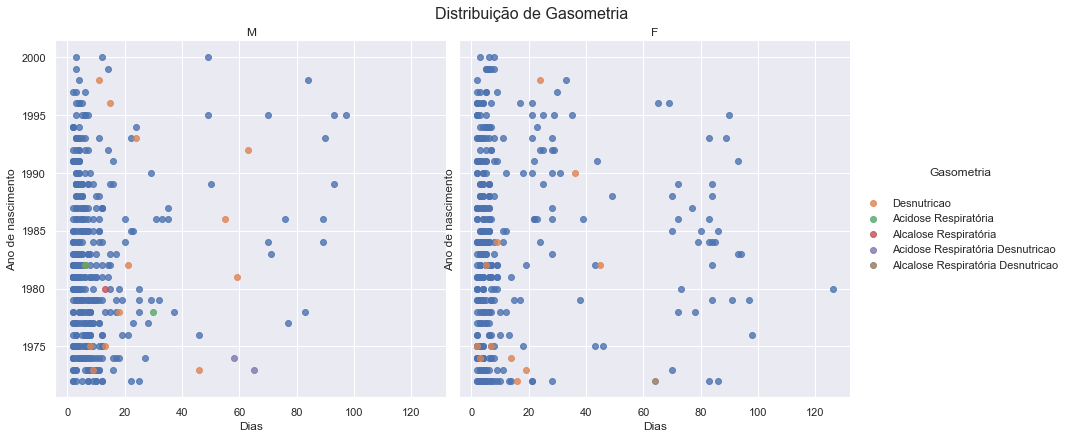

In [81]:
def hueCreate(row): 
    ret = ""
    if(row['ACIDOSE_METABOLICA']):
        ret = "Acidose Metabolica "
    elif(row['ACIDOSE_RESPIRATORIA']):
        ret = "Acidose Respiratória "
    elif(row['ALCALOSE_METABOLICA']):
        ret = "Alcalose Metabólica "
    elif(row['ALCALOSE_RESPIRATORIA']):
        ret = "Alcalose Respiratória "

    if(row['DESNUTRICAO']):
        ret = ret + "Desnutricao"
    
    return ret

cursor = tblPacientes.find({"DAYS": {"$gte": 1}})
df =  pd.DataFrame(list(cursor))

df['HUE'] = df.apply(lambda row: hueCreate(row), axis = 1)

sns.set( rc = {'figure.figsize' : ( 20, 20 ),  'axes.labelsize' : 12 })
ax = sns.lmplot(x='DAYS', y='aa_nascimento',height=6, data=df, fit_reg=False, hue='HUE', col="IC_SEXO") #, markers=[".", "o", "o", "o"])
ax.fig.suptitle("Distribuição de Gasometria", fontsize=16) 
ax.fig.subplots_adjust( top = .9 )
ax._legend.set_title("Gasometria")
ax.set(xlabel='Dias', ylabel='Ano de nascimento')
ax.set_titles(col_template="{col_name}", row_template="{row_name}")
ax.fig.savefig("gosmetria.png")

In [234]:
def hueCreate(row): 
    ret = ""
    if(row['ACIDOSE_METABOLICA']):
        ret = "Acidose Metabolica "
    elif(row['ACIDOSE_RESPIRATORIA']):
        ret = "Acidose Respiratória "
    elif(row['ALCALOSE_METABOLICA']):
        ret = "Alcalose Metabólica "
    elif(row['ALCALOSE_RESPIRATORIA']):
        ret = "Alcalose Respiratória "
    
    if(row['DESNUTRICAO']):
        ret = ret + "Desnutricao"
    
    return ret

cursor = tblPacientes.find({"DE_CLINICA": "Cirurgia"})
df =  pd.DataFrame(list(cursor))
df.head()

Empty DataFrame
Columns: []
Index: []

In [233]:
df['HUE'] = df.apply(lambda row: hueCreate(row), axis = 1)

sns.set( rc = {'figure.figsize' : ( 20, 20 ),  'axes.labelsize' : 12 })
ax = sns.lmplot(x='DAYS', y='aa_nascimento',height=6, data=df, fit_reg=False, hue='HUE', col="IC_SEXO", markers=[".", "o", "o", "o"])
ax.fig.suptitle("Distribuição de Gasometria", fontsize=16) 
ax.fig.subplots_adjust( top = .9 )
ax._legend.set_title("Gasometria")
ax.set(xlabel='Dias', ylabel='Ano de nascimento')
ax.set_titles(col_template="{col_name}", row_template="{row_name}")
ax.fig.savefig("gosmetria.png")

KeyError: "None of [Index(['DAYS', 'HUE', 'IC_SEXO', 'aa_nascimento'], dtype='object')] are in the [columns]"